## Basic MCMC

In this tutorial we will go through how to infer a transmission string from light curve data using the MCMC package, emcee.

To start, let us simulate the transit light curve data for a known transmission string.

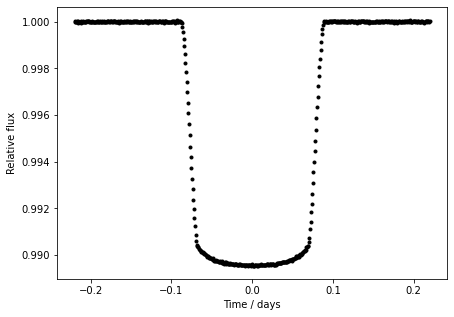

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from harmonica import HarmonicaTransit


np.random.seed(1)
n_obs = 600
times = np.linspace(-0.22, 0.22, n_obs)
us = np.array([0.062, 0.151])
rs = np.array([0.1, -0.006, 0., 0.003, 0.])
var_names = ['a_0', 'a_1', 'b_1', 'a_2', 'b_2']
y_sigma = 20.e-6
y_errs = np.random.normal(loc=0., scale=y_sigma, size=n_obs)

ht = HarmonicaTransit(times, pnl_c=20, pnl_e=20)
ht.set_orbit(t0=0., period=3.735, a=7.025, inc=86.9 * np.pi / 180.)
ht.set_stellar_limb_darkening(us, limb_dark_law='quadratic')
ht.set_planet_transmission_string(rs)
observed_fluxes = ht.get_transit_light_curve() + y_errs

fig, ax1 = plt.subplots(1, figsize=(7, 5))
ax1.errorbar(times, observed_fluxes, yerr=y_sigma, fmt=".k", capsize=0)
ax1.set_xlabel('Time / days')
ax1.set_ylabel('Relative flux')
plt.show()

Now, let us fit this data using the MCMC package, emcee. We will use the typical likelihhod function used for Gaussian distributed uncertainties, and wide normal priors. 

In [2]:
import emcee
import multiprocessing


def log_prob(params):
    """ Typical Gaussian likelihood. """
    # Ln prior.
    ln_prior = -0.5 * np.sum((params[0] / 0.05)**2)
    ln_prior += -0.5 * np.sum((params[1:] / 0.05)**2)

    # Ln likelihood.
    ht.set_planet_transmission_string(params)
    model = ht.get_transit_light_curve()
    ln_like = -0.5 * np.sum((observed_fluxes - model)**2 / y_sigma**2
                            + np.log(2 * np.pi * y_sigma**2))

    return ln_like + ln_prior


coords = np.array([0.1, 0., 0., 0., 0.]) + 1.e-5 * np.random.randn(12, len(rs))
sampler = emcee.EnsembleSampler(coords.shape[0], coords.shape[1], log_prob)
state = sampler.run_mcmc(coords, 10000, progress=True)
chain = sampler.get_chain(discard=5000, flat=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:44<00:00, 14.19it/s]


First, we check the results and convergence.

In [3]:
import arviz as az


emcee_data = az.from_emcee(sampler, var_names)
az.summary(emcee_data, var_names, round_to=6)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_0,0.099985,0.000056,0.099789,0.100022,0.000004,0.000003,398.069267,203.504657,1.044660
a_1,-0.005799,0.000760,-0.006217,-0.004232,0.000082,0.000062,150.198421,207.081060,1.047907
b_1,-0.000564,0.001065,-0.002988,0.000207,0.000107,0.000076,162.354857,255.904659,1.043764
a_2,0.003189,0.000761,0.002433,0.005380,0.000056,0.000043,385.696883,238.069398,1.042948
b_2,0.000214,0.001753,-0.002632,0.004751,0.000131,0.000107,497.363016,204.118052,1.033699


Second, we sample the inferred posterior distribution and look at the resulting transit fit.

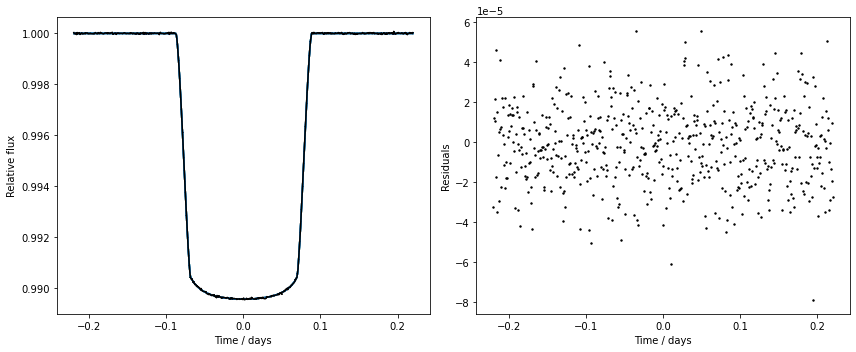

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.errorbar(times, observed_fluxes, yerr=y_sigma, color='#000000', markersize=2, capsize=0)
ht.set_planet_transmission_string(np.median(chain, axis=0))
ax2.scatter(times, ht.get_transit_light_curve() - observed_fluxes, color='#000000', s=2)
for sample in chain[np.random.randint(len(chain), size=50)]:
    ht.set_planet_transmission_string(sample)
    ax1.plot(times, ht.get_transit_light_curve(),
             color='C0', alpha=0.1)
ax1.set_xlabel('Time / days')
ax1.set_ylabel('Relative flux')
ax2.set_xlabel('Time / days')
ax2.set_ylabel('Residuals')
plt.tight_layout()
plt.show()

And third, we look at the resulting transmission string and compare it to the injected model.

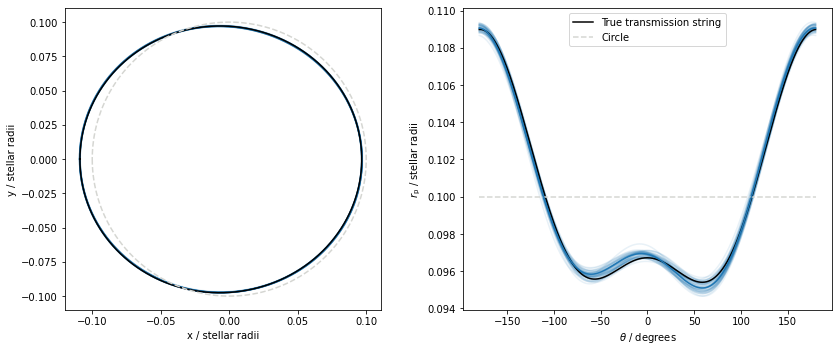

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_aspect('equal', 'box')
labelled = False
theta = np.linspace(-np.pi, np.pi, 1000)

for sample in chain[np.random.randint(len(chain), size=50)]:
    ht.set_planet_transmission_string(sample)
    transmission_string = ht.get_planet_transmission_string(theta)
    ax1.plot(transmission_string * np.cos(theta), transmission_string * np.sin(theta), color='C0', alpha=0.1)
    ax2.plot(theta * 180. / np.pi, transmission_string, color='C0', alpha=0.1)

ht.set_planet_transmission_string(np.median(chain, axis=0))
transmission_string = ht.get_planet_transmission_string(theta)
ax2.plot(theta * 180. / np.pi, transmission_string, color='C0', alpha=1.0)

ht.set_planet_transmission_string(rs)
ax1.plot(transmission_string * np.cos(theta), transmission_string * np.sin(theta), lw=1.5, c='#000000')
ax2.plot(theta * 180. / np.pi, transmission_string, c='#000000', lw=1.5, label='True transmission string')
ax1.plot(rs[0] * np.cos(theta), rs[0] * np.sin(theta), lw=1.5, c='#d5d6d2', ls='--')
ax2.plot(theta * 180. / np.pi, np.ones(theta.shape[0]) * rs[0], c='#d5d6d2', lw=1.5, ls='--', label='Circle')

ax2.legend(loc='upper center')
ax1.set_xlabel('x / stellar radii')
ax1.set_ylabel('y / stellar radii')
ax2.set_xlabel('$\\theta$ / degrees')
ax2.set_ylabel('$r_{\\rm{p}}$ / stellar radii')
plt.tight_layout()
plt.show()